In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal
import scipy
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams.update({'font.size': 16})

In [2]:
def monthly_to_annual(array):
    """ calculate annual mena from monthly data, using unequal month lengths fros noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

def savgol_filter(array, window, order=2):
    smooth_array = array.copy()
    smooth_array[:] = scipy.signal.savgol_filter(array, window, order)
    return(smooth_array)

In [3]:
conv_fact_ppm_to_pg = 2.12 # Pg C / ppm


In [4]:
fin_cdr_atm = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10-cdr.001.atm_vars.nc')
fin_cdr_lnd = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10-cdr.001.lnd_vars.nc')
fin_cdr_ocn = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10-cdr.001.ocn_vars.nc')
fin_flat10_atm = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10-esm.001.atm_vars.nc')
fin_flat10_lnd = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10-esm.001.lnd_vars.nc')
fin_flat10_ocn = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10-esm.001.ocn_vars.nc')
fin_zec_atm = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10-zec.001.atm_vars.nc')
fin_zec_lnd = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10-zec.001.lnd_vars.nc')
fin_zec_ocn = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10-zec.001.ocn_vars.nc')
fin_ctrl_atm = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10ctrl-esm.001.atm_vars.nc')
fin_ctrl_lnd = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10ctrl-esm.001.lnd_vars.nc')
fin_ctrl_ocn = xr.open_dataset('b.e21.B1850.f09_g17.FLAT10ctrl-esm.001.ocn_vars.nc')

areacella = xr.open_dataset('areacella_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
areacello = xr.open_dataset('areacello_Ofx_CESM2_1pctCO2_r1i1p1f1_gn.nc')

sftlf = xr.open_dataset('sftlf_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
sftgif = xr.open_dataset('sftgif_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')

/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'sftgif' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


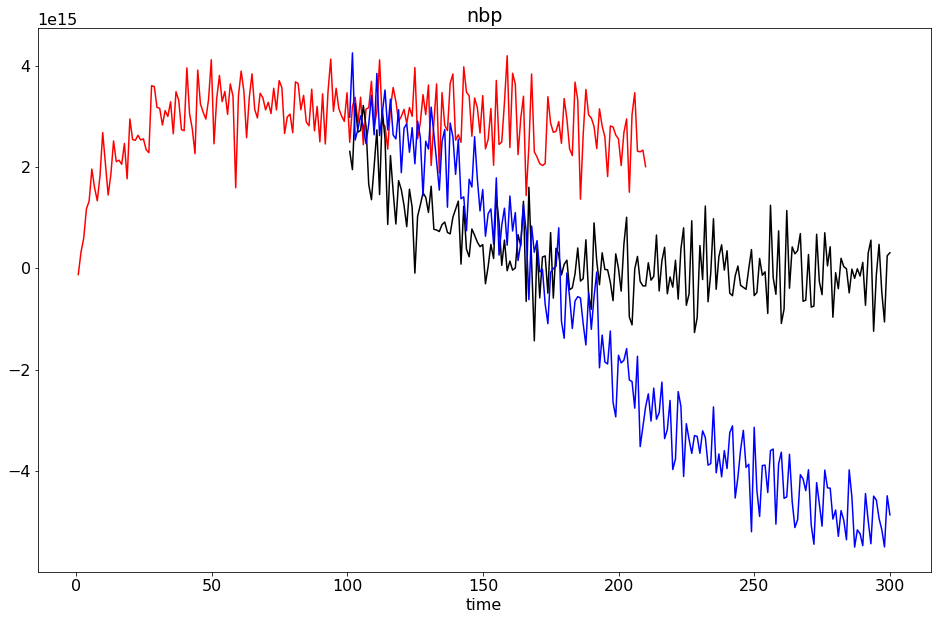

In [5]:
nbp_global_flat10 = (-fin_flat10_lnd['NEE'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
nbp_global_flat10['time'] = np.arange(len(nbp_global_flat10['time']))/12.
nbp_global_flat10 = (monthly_to_annual(nbp_global_flat10)*86400. * 365.)
nbp_global_flat10.plot(color='red')

nbp_global_zec = (-fin_zec_lnd['NEE'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
nbp_global_zec['time'] = np.arange(len(nbp_global_zec['time']))/12. + 100.
nbp_global_zec = (monthly_to_annual(nbp_global_zec)*86400. * 365.)
nbp_global_zec.plot(color='black')

nbp_global_cdr = (-fin_cdr_lnd['NEE'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
nbp_global_cdr['time'] = np.arange(len(nbp_global_cdr['time']))/12. + 100.
nbp_global_cdr = (monthly_to_annual(nbp_global_cdr)*86400. * 365.)
nbp_global_cdr.plot(color='blue')
plt.title('nbp')

nbp_global_flat10.to_dataset(name='nbp').to_netcdf('flat10_nbp_CESM2.nc')
nbp_global_zec.to_dataset(name='nbp').to_netcdf('flat10_zec_nbp_CESM2.nc')
nbp_global_cdr.to_dataset(name='nbp').to_netcdf('flat10_cdr_nbp_CESM2.nc')


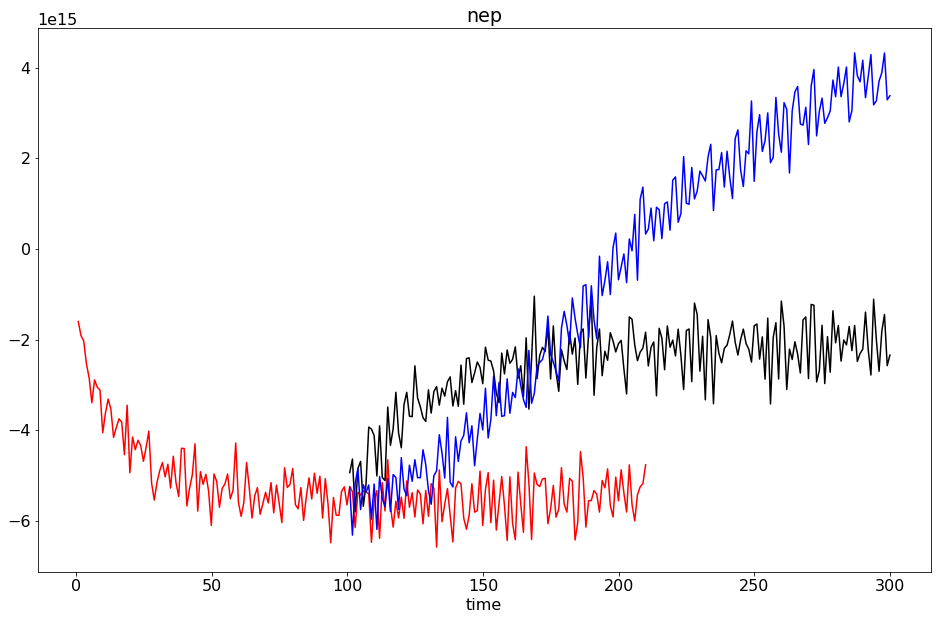

In [6]:
nep_global_flat10 = (-fin_flat10_lnd['NEP'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
nep_global_flat10['time'] = np.arange(len(nep_global_flat10['time']))/12.
nep_global_flat10 = (monthly_to_annual(nep_global_flat10)*86400. * 365.)
nep_global_flat10.plot(color='red')

nep_global_zec = (-fin_zec_lnd['NEP'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
nep_global_zec['time'] = np.arange(len(nep_global_zec['time']))/12. + 100.
nep_global_zec = (monthly_to_annual(nep_global_zec)*86400. * 365.)
nep_global_zec.plot(color='black')

nep_global_cdr = (-fin_cdr_lnd['NEP'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
nep_global_cdr['time'] = np.arange(len(nep_global_cdr['time']))/12. + 100.
nep_global_cdr = (monthly_to_annual(nep_global_cdr)*86400. * 365.)
nep_global_cdr.plot(color='blue')
plt.title('nep')

nep_global_flat10.to_dataset(name='nep').to_netcdf('flat10_nep_CESM2.nc')
nep_global_zec.to_dataset(name='nep').to_netcdf('flat10_zec_nep_CESM2.nc')
nep_global_cdr.to_dataset(name='nep').to_netcdf('flat10_cdr_nep_CESM2.nc')


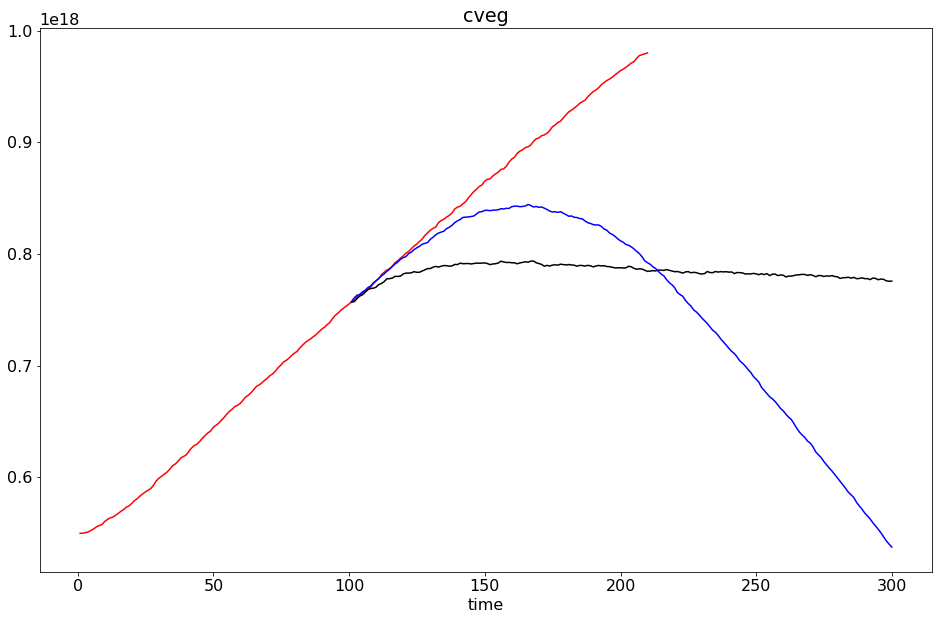

In [7]:
cveg_global_flat10 = (fin_flat10_lnd['TOTVEGC'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
cveg_global_flat10['time'] = np.arange(len(cveg_global_flat10['time']))/12.
cveg_global_flat10 = (monthly_to_annual(cveg_global_flat10))
cveg_global_flat10.plot(color='red')

cveg_global_zec = (fin_zec_lnd['TOTVEGC'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
cveg_global_zec['time'] = np.arange(len(cveg_global_zec['time']))/12. + 100.
cveg_global_zec = (monthly_to_annual(cveg_global_zec))
cveg_global_zec.plot(color='black')

cveg_global_cdr = (fin_cdr_lnd['TOTVEGC'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
cveg_global_cdr['time'] = np.arange(len(cveg_global_cdr['time']))/12. + 100.
cveg_global_cdr = (monthly_to_annual(cveg_global_cdr))
cveg_global_cdr.plot(color='blue')
plt.title('cveg')

cveg_global_flat10.to_dataset(name='cveg').to_netcdf('flat10_cveg_CESM2.nc')
cveg_global_zec.to_dataset(name='cveg').to_netcdf('flat10_zec_cveg_CESM2.nc')
cveg_global_cdr.to_dataset(name='cveg').to_netcdf('flat10_cdr_cveg_CESM2.nc')


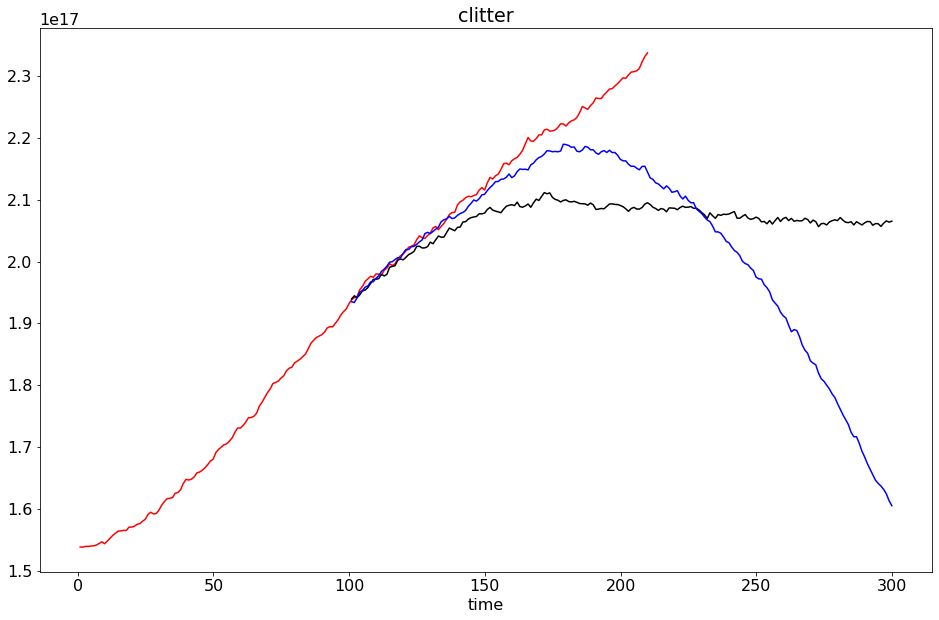

In [8]:
clitter_global_flat10 = ((fin_flat10_lnd['CWDC'] + fin_flat10_lnd['TOTLITC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
clitter_global_flat10['time'] = np.arange(len(clitter_global_flat10['time']))/12.
clitter_global_flat10 = (monthly_to_annual(clitter_global_flat10))
clitter_global_flat10.plot(color='red')

clitter_global_zec = ((fin_zec_lnd['CWDC'] + fin_zec_lnd['TOTLITC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
clitter_global_zec['time'] = np.arange(len(clitter_global_zec['time']))/12. + 100.
clitter_global_zec = (monthly_to_annual(clitter_global_zec))
clitter_global_zec.plot(color='black')

clitter_global_cdr = ((fin_cdr_lnd['CWDC'] + fin_cdr_lnd['TOTLITC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
clitter_global_cdr['time'] = np.arange(len(clitter_global_cdr['time']))/12. + 100.
clitter_global_cdr = (monthly_to_annual(clitter_global_cdr))
clitter_global_cdr.plot(color='blue')
plt.title('clitter')

clitter_global_flat10.to_dataset(name='clitter').to_netcdf('flat10_clitter_CESM2.nc')
clitter_global_zec.to_dataset(name='clitter').to_netcdf('flat10_zec_clitter_CESM2.nc')
clitter_global_cdr.to_dataset(name='clitter').to_netcdf('flat10_cdr_clitter_CESM2.nc')


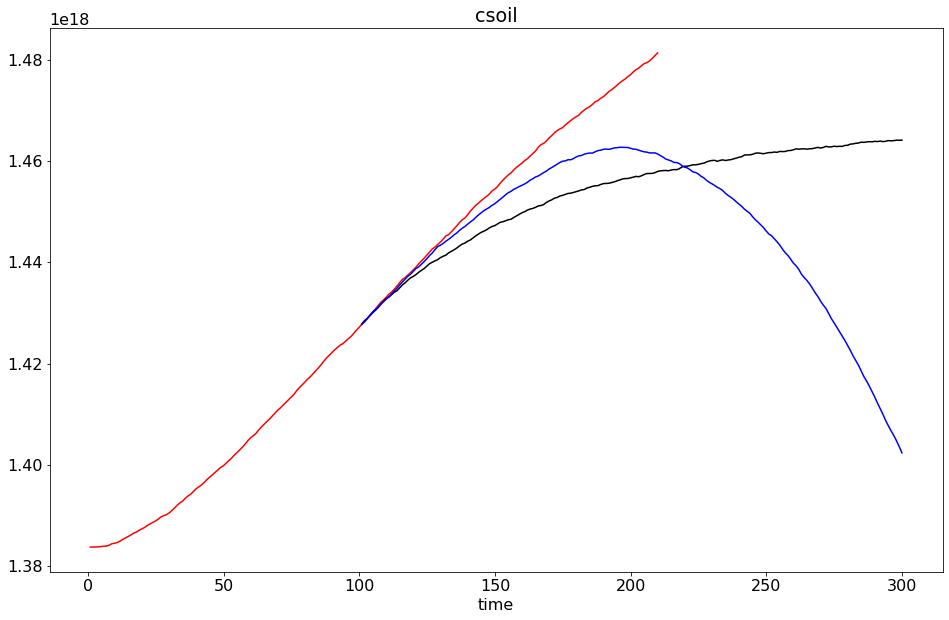

In [9]:
csoil_global_flat10 = ((fin_flat10_lnd['TOTSOMC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
csoil_global_flat10['time'] = np.arange(len(csoil_global_flat10['time']))/12.
csoil_global_flat10 = (monthly_to_annual(csoil_global_flat10))
csoil_global_flat10.plot(color='red')

csoil_global_zec = ((fin_zec_lnd['TOTSOMC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
csoil_global_zec['time'] = np.arange(len(csoil_global_zec['time']))/12. + 100.
csoil_global_zec = (monthly_to_annual(csoil_global_zec))
csoil_global_zec.plot(color='black')

csoil_global_cdr = ((fin_cdr_lnd['TOTSOMC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
csoil_global_cdr['time'] = np.arange(len(csoil_global_cdr['time']))/12. + 100.
csoil_global_cdr = (monthly_to_annual(csoil_global_cdr))
csoil_global_cdr.plot(color='blue')
plt.title('csoil')

csoil_global_flat10.to_dataset(name='csoil').to_netcdf('flat10_csoil_CESM2.nc')
csoil_global_zec.to_dataset(name='csoil').to_netcdf('flat10_zec_csoil_CESM2.nc')
csoil_global_cdr.to_dataset(name='csoil').to_netcdf('flat10_cdr_csoil_CESM2.nc')


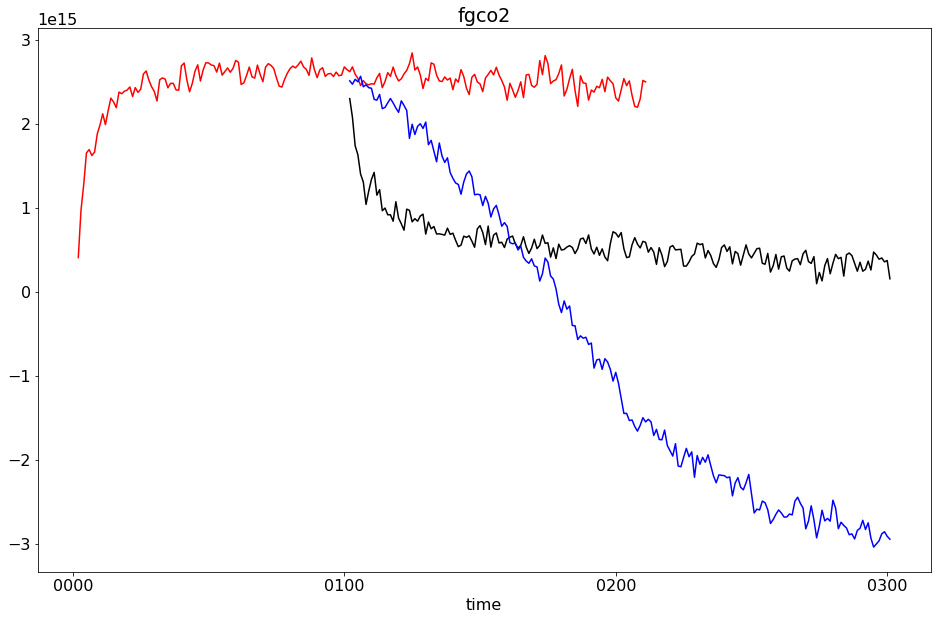

In [10]:
fgco2_global_flat10 = (fin_flat10_ocn['FG_CO2'] * areacello['areacello'].data * 12.0e-8 * 86400. * 365. * 1e3).sum(dim=('nlat', 'nlon'))
fgco2_global_annual_flat10 = monthly_to_annual(fgco2_global_flat10)
fgco2_global_annual_flat10.plot(color='red')

fgco2_global_zec = (fin_zec_ocn['FG_CO2'] * areacello['areacello'].data * 12.0e-8 * 86400. * 365. * 1e3).sum(dim=('nlat', 'nlon'))
fgco2_global_annual_zec = monthly_to_annual(fgco2_global_zec)
fgco2_global_annual_zec.plot(color='black')

fgco2_global_cdr = (fin_cdr_ocn['FG_CO2'] * areacello['areacello'].data * 12.0e-8 * 86400. * 365. * 1e3).sum(dim=('nlat', 'nlon'))
fgco2_global_annual_cdr = monthly_to_annual(fgco2_global_cdr)
fgco2_global_annual_cdr.plot(color='blue')

plt.title('fgco2')


fgco2_global_flat10.to_dataset(name='fgco2').to_netcdf('flat10_fgco2_CESM2.nc')
fgco2_global_zec.to_dataset(name='fgco2').to_netcdf('flat10_zec_fgco2_CESM2.nc')
fgco2_global_cdr.to_dataset(name='fgco2').to_netcdf('flat10_cdr_fgco2_CESM2.nc')

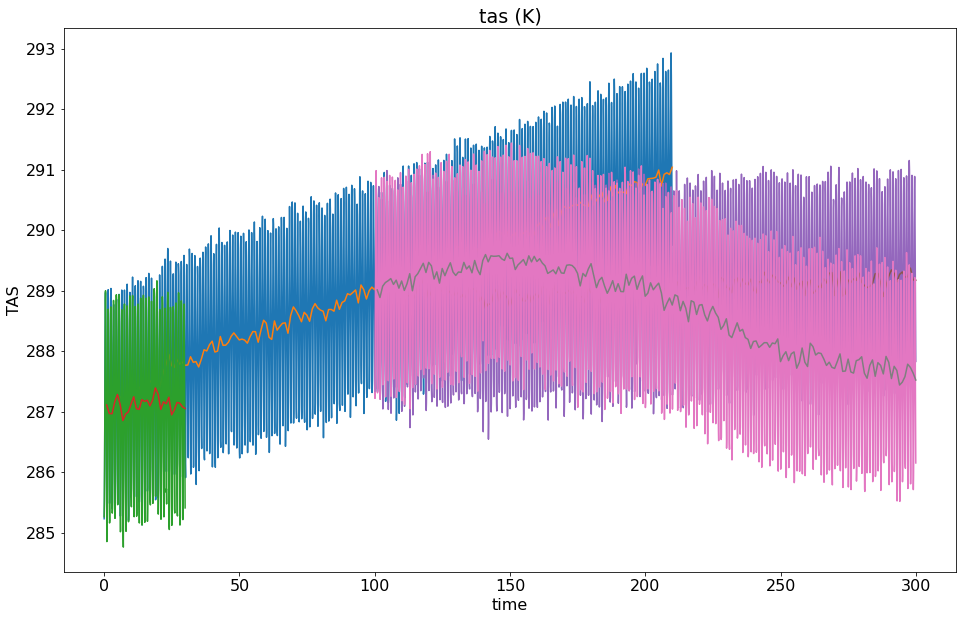

In [11]:
gmst_flat10 =  (fin_flat10_atm['TREFHT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
gmst_flat10['time'] = np.arange(len(gmst_flat10['time']))/12.
gmst_annual_flat10 = monthly_to_annual(gmst_flat10)
gmst_annual_flat10.attrs['long_name'] = 'TAS'
gmst_flat10.attrs['long_name'] = 'TAS'
gmst_flat10.plot()
gmst_annual_flat10.plot()

gmst_ctrl =  (fin_ctrl_atm['TREFHT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
gmst_ctrl['time'] = np.arange(len(gmst_ctrl['time']))/12.
gmst_annual_ctrl = monthly_to_annual(gmst_ctrl)
gmst_annual_ctrl.attrs['long_name'] = 'TAS'
gmst_ctrl.attrs['long_name'] = 'TAS'
gmst_ctrl.plot()
gmst_annual_ctrl.plot()

gmst_zec =  (fin_zec_atm['TREFHT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
gmst_zec['time'] = np.arange(len(gmst_zec['time']))/12. + 100.
gmst_annual_zec = monthly_to_annual(gmst_zec)
gmst_annual_zec.attrs['long_name'] = 'TAS'
gmst_zec.attrs['long_name'] = 'TAS'
gmst_zec.plot()
gmst_annual_zec.plot()

gmst_cdr =  (fin_cdr_atm['TREFHT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
gmst_cdr['time'] = np.arange(len(gmst_cdr['time']))/12. + 100.
gmst_annual_cdr = monthly_to_annual(gmst_cdr)
gmst_annual_cdr.attrs['long_name'] = 'TAS'
gmst_cdr.attrs['long_name'] = 'TAS'
gmst_cdr.plot()
gmst_annual_cdr.plot()


plt.title('tas (K)')


gmst_annual_flat10.to_dataset(name='tas').to_netcdf('flat10_gmst_CESM2.nc')
gmst_annual_zec.to_dataset(name='tas').to_netcdf('flat10_zec_gmst_CESM2.nc')
gmst_annual_cdr.to_dataset(name='tas').to_netcdf('flat10_cdr_gmst_CESM2.nc')
gmst_annual_ctrl.to_dataset(name='tas').to_netcdf('flat10_ctrl_gmst_CESM2.nc')

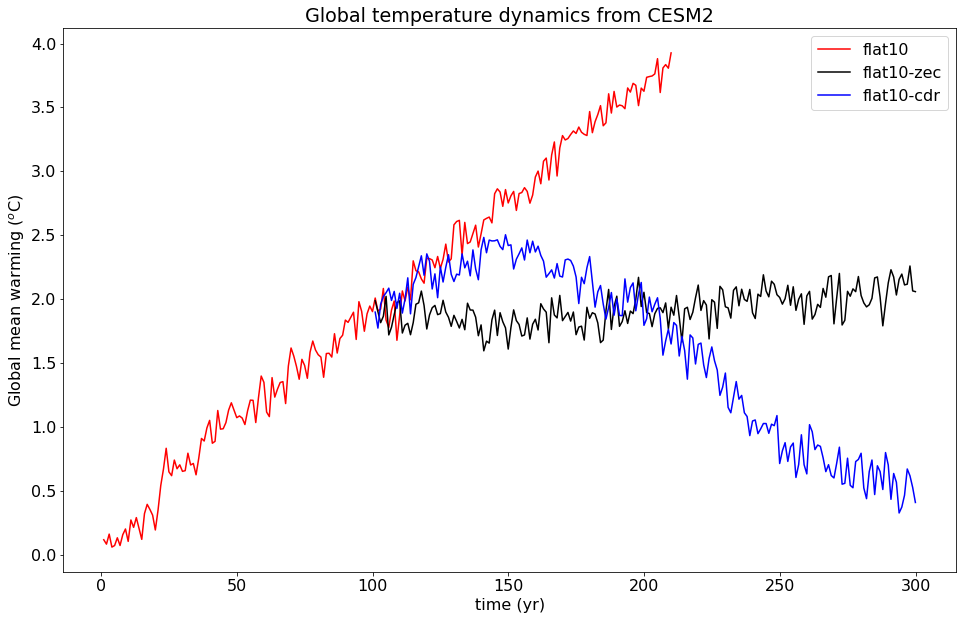

In [12]:
warming_flat10 = gmst_annual_flat10 - gmst_annual_ctrl.mean(dim='time')
warming_zec = gmst_annual_zec - gmst_annual_ctrl.mean(dim='time')
warming_cdr = gmst_annual_cdr - gmst_annual_ctrl.mean(dim='time')

warming_flat10.plot(color='red')
warming_zec.plot(color='black')
warming_cdr.plot(color='blue')

plt.title('Global temperature dynamics from CESM2')
plt.ylabel('Global mean warming ($^o$C)')
plt.xlabel('time (yr)')
plt.legend(['flat10','flat10-zec','flat10-cdr'])

In [13]:
emiss_flat10 = 10. * gmst_annual_flat10['time']/gmst_annual_flat10['time']
emiss_flat10_cum = emiss_flat10.cumsum()

emiss_zec = 0. * gmst_annual_zec['time']/gmst_annual_zec['time']
emiss_zec_cum = emiss_zec.cumsum() + 1000.

emiss_cdr = gmst_annual_cdr['time']/gmst_annual_cdr['time']
emiss_cdr[0:100] = 10.-0.2*emiss_cdr[0:100]*np.arange(100)
emiss_cdr[100:] = -10.*emiss_cdr[100:]
emiss_cdr_cum = emiss_cdr.cumsum() + 1000.

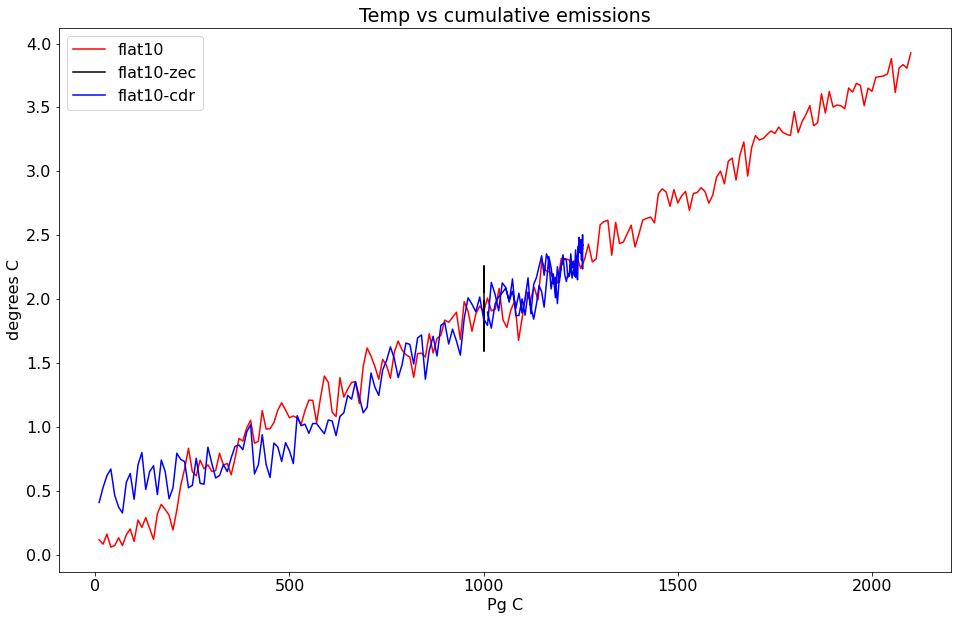

In [14]:
plt.plot(emiss_flat10_cum,warming_flat10, color='red')
plt.plot(emiss_zec_cum,warming_zec, color='black')
plt.plot(emiss_cdr_cum,warming_cdr, color='blue')

plt.title('Temp vs cumulative emissions')
plt.ylabel('degrees C')
plt.xlabel('Pg C')
plt.legend(['flat10','flat10-zec','flat10-cdr'])

### redo the land, but for live and dead carbon separately

In [15]:
cveg_global_flat10 = (fin_flat10_lnd['TOTVEGC'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
cveg_global_zec = (fin_zec_lnd['TOTVEGC'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
cveg_global_cdr = (fin_cdr_lnd['TOTVEGC'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))

csoil_global_flat10 = ((fin_flat10_lnd['TOTSOMC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
csoil_global_zec = ((fin_zec_lnd['TOTSOMC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
csoil_global_cdr = ((fin_cdr_lnd['TOTSOMC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))

clitter_global_flat10 = ((fin_flat10_lnd['TOTLITC']+fin_flat10_lnd['CWDC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
clitter_global_zec = ((fin_zec_lnd['TOTLITC']+fin_zec_lnd['CWDC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
clitter_global_cdr = ((fin_cdr_lnd['TOTLITC']+fin_cdr_lnd['CWDC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))

                                            

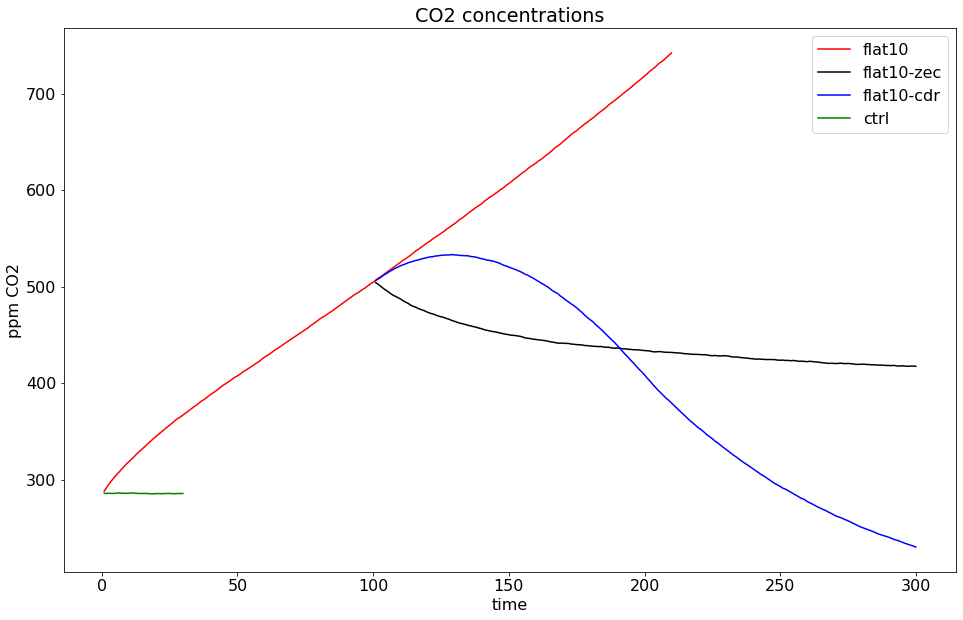

In [16]:

tmco2_flat10 =  (fin_flat10_atm['TMCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) * 1.e-12 * (12/44) / conv_fact_ppm_to_pg
tmco2_flat10['time'] = np.arange(len(tmco2_flat10['time']))/12.
tmco2_annual_flat10 = monthly_to_annual(tmco2_flat10)
#tmco2_flat10.plot()
tmco2_annual_flat10.plot(color='red')

tmco2_zec =  (fin_zec_atm['TMCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) * 1.e-12 * (12/44) / conv_fact_ppm_to_pg
tmco2_zec['time'] = np.arange(len(tmco2_zec['time']))/12. + 100.
tmco2_annual_zec = monthly_to_annual(tmco2_zec)
#tmco2_zec.plot()
tmco2_annual_zec.plot(color='black')

tmco2_cdr =  (fin_cdr_atm['TMCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) * 1.e-12 * (12/44) / conv_fact_ppm_to_pg
tmco2_cdr['time'] = np.arange(len(tmco2_cdr['time']))/12. + 100.
tmco2_annual_cdr = monthly_to_annual(tmco2_cdr)
#tmco2_cdr.plot()
tmco2_annual_cdr.plot(color='blue')

tmco2_ctrl =  (fin_ctrl_atm['TMCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) * 1.e-12 * (12/44) / conv_fact_ppm_to_pg
tmco2_ctrl['time'] = np.arange(len(tmco2_ctrl['time']))/12.
tmco2_annual_ctrl = monthly_to_annual(tmco2_ctrl)
#tmco2_ctrl.plot()
tmco2_annual_ctrl.plot(color='green')

plt.title('CO2 concentrations')
plt.ylabel('ppm CO2')
plt.xlabel('time')
plt.legend(['flat10','flat10-zec','flat10-cdr', 'ctrl'])



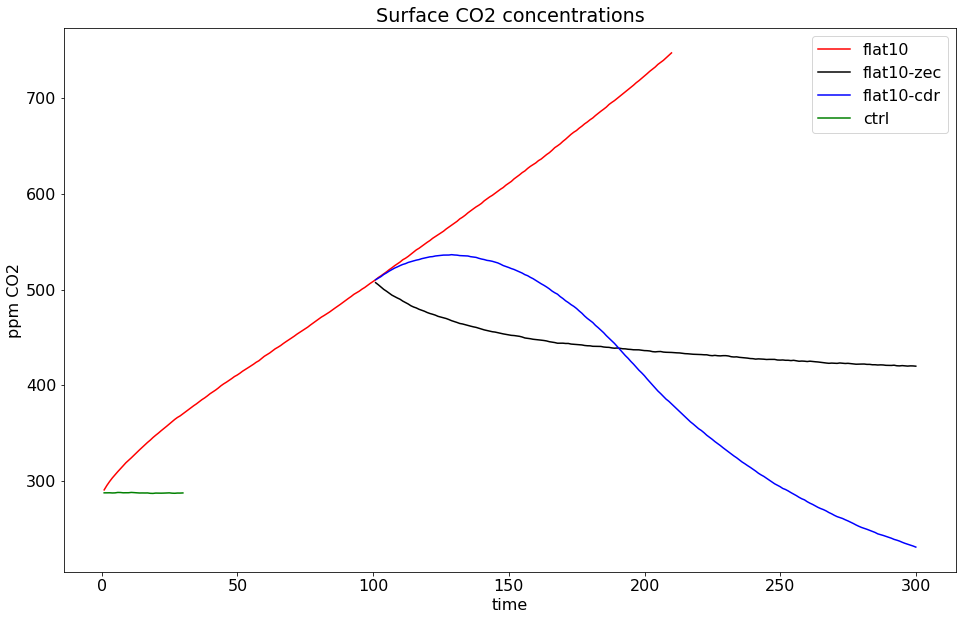

In [17]:
molar_mass_dry_air = 28.9647  # g / mol
molar_mass_co2 = 44.

co2_flat10 =  (fin_flat10_atm['CO2'].isel(lev=-1) * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
co2_flat10['time'] = np.arange(len(co2_flat10['time']))/12.
co2_annual_flat10 = monthly_to_annual(co2_flat10) * 1e6 * molar_mass_dry_air / molar_mass_co2
co2_annual_flat10.plot(color='red')

co2_zec =  (fin_zec_atm['CO2'].isel(lev=-1) * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
co2_zec['time'] = np.arange(len(co2_zec['time']))/12. + 100.
co2_annual_zec = monthly_to_annual(co2_zec) * 1e6 * molar_mass_dry_air / molar_mass_co2
co2_annual_zec.plot(color='black')

co2_cdr =  (fin_cdr_atm['CO2'].isel(lev=-1) * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
co2_cdr['time'] = np.arange(len(co2_cdr['time']))/12. + 100.
co2_annual_cdr = monthly_to_annual(co2_cdr) * 1e6 * molar_mass_dry_air / molar_mass_co2
co2_annual_cdr.plot(color='blue')

co2_ctrl =  (fin_ctrl_atm['CO2'].isel(lev=-1) * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
co2_ctrl['time'] = np.arange(len(co2_ctrl['time']))/12.
co2_annual_ctrl = monthly_to_annual(co2_ctrl) * 1e6 * molar_mass_dry_air / molar_mass_co2
co2_annual_ctrl.plot(color='green')



plt.title('Surface CO2 concentrations')
plt.ylabel('ppm CO2')
plt.xlabel('time')
plt.legend(['flat10','flat10-zec','flat10-cdr', 'ctrl'])

In [18]:
fin_flat10_atm

<xarray.Dataset>
Dimensions:    (lat: 192, zlon: 1, nbnd: 2, lon: 288, lev: 32, ilev: 33,
                time: 2520)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon       (zlon) float64 0.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * ilev       (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time       (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/25)
    zlon_bnds  (zlon, nbnd) float64 ...
    hyam       (lev) float64 ...
    hybm       (lev) float64 ...
    P0         float64 ...
    hyai       (ilev) float64 ...
    hybi       (ilev) float64 ...
    ...         ...
    SFCO2      (time, lat, lon) float32 ...
    SFCO2_FFF  (time, lat, lon) float32 ...
    SFCO2_LND  (time, lat, lon) float32 ...
    SFCO2_OCN  (time, lat, lon) float32 ...
    TMCO2      (time, lat, lon) float32 3.028 3.028 3.028 ... 11.59 11.59 11.59
    TREFHT     (time, lat, lon) float32 243.8 243.8 243.8 ... 259.6 259.6 259.6
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.B1850.f09_g17.FLAT10-esm.001
    logname:           lawrence
    host:              derecho4
    initial_file:      b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.cam.i.0151...
    topography_file:   /glade/p/cesmdata/inputdata/atm/cam/topo/fv_0.9x1.25_n...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    history:           Mon Dec 18 16:52:24 2023: ncrcat -4 -L 5 -O -cv TMCO2,...
    NCO:               netCDF Operators version 5.1.4 (Homepage = http://nco....

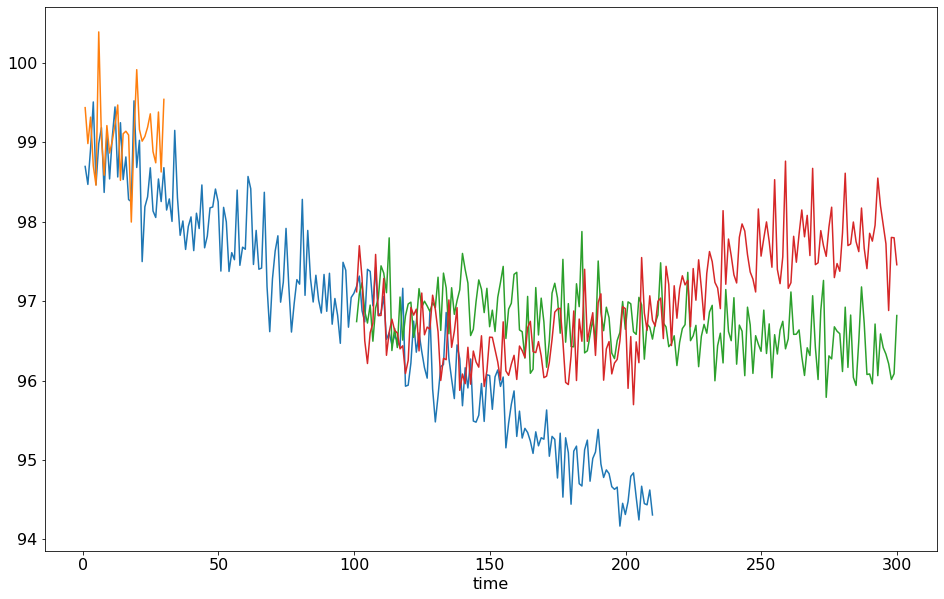

In [19]:
rsut_flat10 =  (fin_flat10_atm['FSUTOA'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rsut_flat10['time'] = np.arange(len(rsut_flat10['time']))/12.
rsut_annual_flat10 = monthly_to_annual(rsut_flat10)
rsut_annual_flat10.plot()

rsut_ctrl =  (fin_ctrl_atm['FSUTOA'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rsut_ctrl['time'] = np.arange(len(rsut_ctrl['time']))/12.
rsut_annual_ctrl = monthly_to_annual(rsut_ctrl)
rsut_annual_ctrl.plot()

rsut_zec =  (fin_zec_atm['FSUTOA'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rsut_zec['time'] = np.arange(len(rsut_zec['time']))/12. + 100.
rsut_annual_zec = monthly_to_annual(rsut_zec)
rsut_annual_zec.plot()

rsut_cdr =  (fin_cdr_atm['FSUTOA'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rsut_cdr['time'] = np.arange(len(rsut_cdr['time']))/12. + 100.
rsut_annual_cdr = monthly_to_annual(rsut_cdr)
rsut_annual_cdr.plot()


rsut_annual_flat10.to_dataset(name='rsut').to_netcdf('flat10_rsut_CESM2.nc')
rsut_annual_zec.to_dataset(name='rsut').to_netcdf('flat10_zec_rsut_CESM2.nc')
rsut_annual_cdr.to_dataset(name='rsut').to_netcdf('flat10_cdr_rsut_CESM2.nc')
rsut_annual_ctrl.to_dataset(name='rsut').to_netcdf('flat10_ctrl_rsut_CESM2.nc')


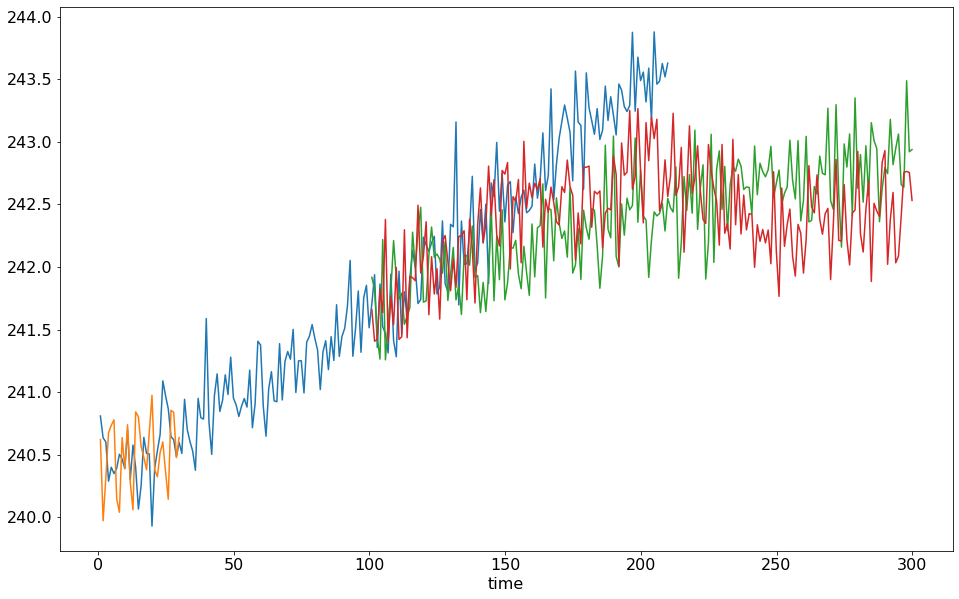

In [20]:
rlut_flat10 =  (fin_flat10_atm['FLUT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rlut_flat10['time'] = np.arange(len(rlut_flat10['time']))/12.
rlut_annual_flat10 = monthly_to_annual(rlut_flat10)
rlut_annual_flat10.plot()

rlut_ctrl =  (fin_ctrl_atm['FLUT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rlut_ctrl['time'] = np.arange(len(rlut_ctrl['time']))/12.
rlut_annual_ctrl = monthly_to_annual(rlut_ctrl)
rlut_annual_ctrl.plot()

rlut_zec =  (fin_zec_atm['FLUT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rlut_zec['time'] = np.arange(len(rlut_zec['time']))/12. + 100.
rlut_annual_zec = monthly_to_annual(rlut_zec)
rlut_annual_zec.plot()

rlut_cdr =  (fin_cdr_atm['FLUT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rlut_cdr['time'] = np.arange(len(rlut_cdr['time']))/12. + 100.
rlut_annual_cdr = monthly_to_annual(rlut_cdr)
rlut_annual_cdr.plot()


rlut_annual_flat10.to_dataset(name='rlut').to_netcdf('flat10_rlut_CESM2.nc')
rlut_annual_zec.to_dataset(name='rlut').to_netcdf('flat10_zec_rlut_CESM2.nc')
rlut_annual_cdr.to_dataset(name='rlut').to_netcdf('flat10_cdr_rlut_CESM2.nc')
rlut_annual_ctrl.to_dataset(name='rlut').to_netcdf('flat10_ctrl_rlut_CESM2.nc')


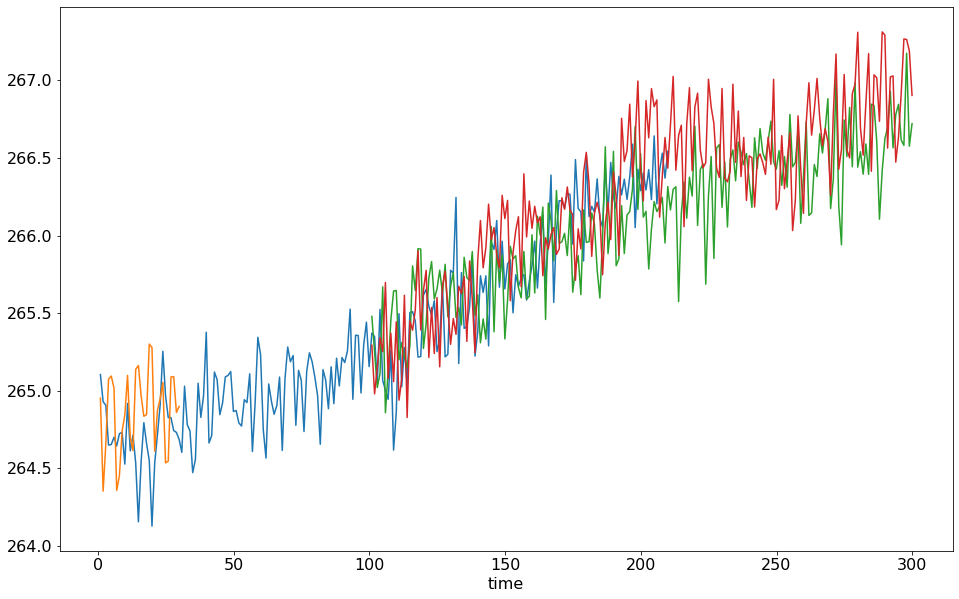

In [21]:
rlutcs_flat10 =  (fin_flat10_atm['FLUTC'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rlutcs_flat10['time'] = np.arange(len(rlutcs_flat10['time']))/12.
rlutcs_annual_flat10 = monthly_to_annual(rlutcs_flat10)
rlutcs_annual_flat10.plot()

rlutcs_ctrl =  (fin_ctrl_atm['FLUTC'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rlutcs_ctrl['time'] = np.arange(len(rlutcs_ctrl['time']))/12.
rlutcs_annual_ctrl = monthly_to_annual(rlutcs_ctrl)
rlutcs_annual_ctrl.plot()

rlutcs_zec =  (fin_zec_atm['FLUTC'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rlutcs_zec['time'] = np.arange(len(rlutcs_zec['time']))/12. + 100.
rlutcs_annual_zec = monthly_to_annual(rlutcs_zec)
rlutcs_annual_zec.plot()

rlutcs_cdr =  (fin_cdr_atm['FLUTC'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rlutcs_cdr['time'] = np.arange(len(rlutcs_cdr['time']))/12. + 100.
rlutcs_annual_cdr = monthly_to_annual(rlutcs_cdr)
rlutcs_annual_cdr.plot()


rlutcs_annual_flat10.to_dataset(name='rlutcs').to_netcdf('flat10_rlutcs_CESM2.nc')
rlutcs_annual_zec.to_dataset(name='rlutcs').to_netcdf('flat10_zec_rlutcs_CESM2.nc')
rlutcs_annual_cdr.to_dataset(name='rlutcs').to_netcdf('flat10_cdr_rlutcs_CESM2.nc')
rlutcs_annual_ctrl.to_dataset(name='rlutcs').to_netcdf('flat10_ctrl_rlutcs_CESM2.nc')


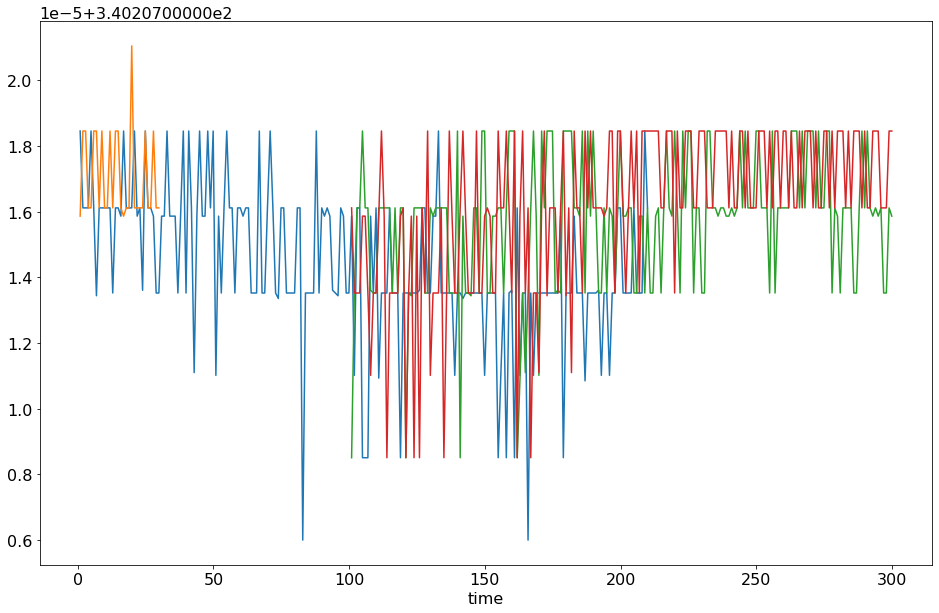

In [22]:
rsdt_flat10 =  ((fin_flat10_atm['FSUTOA'] + fin_flat10_atm['FSNTOA'] )* areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rsdt_flat10['time'] = np.arange(len(rsdt_flat10['time']))/12.
rsdt_annual_flat10 = monthly_to_annual(rsdt_flat10)
rsdt_annual_flat10.plot()

rsdt_ctrl =  ((fin_ctrl_atm['FSUTOA'] + fin_ctrl_atm['FSNTOA'] ) * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rsdt_ctrl['time'] = np.arange(len(rsdt_ctrl['time']))/12.
rsdt_annual_ctrl = monthly_to_annual(rsdt_ctrl)
rsdt_annual_ctrl.plot()

rsdt_zec =  ((fin_zec_atm['FSUTOA'] + fin_zec_atm['FSNTOA'] ) * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rsdt_zec['time'] = np.arange(len(rsdt_zec['time']))/12. + 100.
rsdt_annual_zec = monthly_to_annual(rsdt_zec)
rsdt_annual_zec.plot()

rsdt_cdr =  ((fin_cdr_atm['FSUTOA'] + fin_cdr_atm['FSNTOA'] ) * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
rsdt_cdr['time'] = np.arange(len(rsdt_cdr['time']))/12. + 100.
rsdt_annual_cdr = monthly_to_annual(rsdt_cdr)
rsdt_annual_cdr.plot()


rsdt_annual_flat10.to_dataset(name='rsdt').to_netcdf('flat10_rsdt_CESM2.nc')
rsdt_annual_zec.to_dataset(name='rsdt').to_netcdf('flat10_zec_rsdt_CESM2.nc')
rsdt_annual_cdr.to_dataset(name='rsdt').to_netcdf('flat10_cdr_rsdt_CESM2.nc')
rsdt_annual_ctrl.to_dataset(name='rsdt').to_netcdf('flat10_ctrl_rsdt_CESM2.nc')


In [23]:
tas_1pctco2 = xr.open_mfdataset('tas_Amon_CESM2_1pctCO2_r1i1p1f1_gn_*.nc')
tas_1pctco2_anual_global = (tas_1pctco2['tas'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
tas_1pctco2_anual_global_annual = monthly_to_annual(tas_1pctco2_anual_global)

warming_1pctco2 = tas_1pctco2_anual_global_annual - gmst_annual_ctrl.mean(dim='time')
co2_1pctco2 = 284.7 * 1.01 ** np.arange(len(tas_1pctco2_anual_global_annual))

/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [24]:
## open 1pctco2 csv files
co2_1pctco2 = np.loadtxt('co2_cesm2_1pctco2_0001_0150.csv', delimiter=',')[:,1]
warming_1pctco2 = np.loadtxt('tas_cesm2_1pctco2_0001_0150.csv', delimiter=',')[:,1] - gmst_annual_ctrl.mean(dim='time').data
fgco2_1pctco2 = np.loadtxt('fgco2_cesm2_1pctco2_0001_0150.csv', delimiter=',')[:,1]
nbp_1pctco2 = np.loadtxt('nbp_cesm2_1pctco2_0001_0150.csv', delimiter=',')[:,1]
atm_sink_cum = (co2_1pctco2  - co2_1pctco2[0]) * conv_fact_ppm_to_pg

emissions_1pctco2 = atm_sink_cum + fgco2_1pctco2.cumsum() + nbp_1pctco2.cumsum()


In [25]:
## open zecmip csv files
zec_co2 = np.loadtxt('co2_cesm2_esm-1pct-brch-1000PgC_0001_0150.csv', delimiter=',')[:,1]
zec_tas = np.loadtxt('tas_cesm2_esm-1pct-brch-1000PgC_0001_0150.csv', delimiter=',')[:,1] - gmst_annual_ctrl.mean(dim='time').data


In [26]:
ladder_times = np.arange(0.,215.,5)
ladder_times[-1] = 209


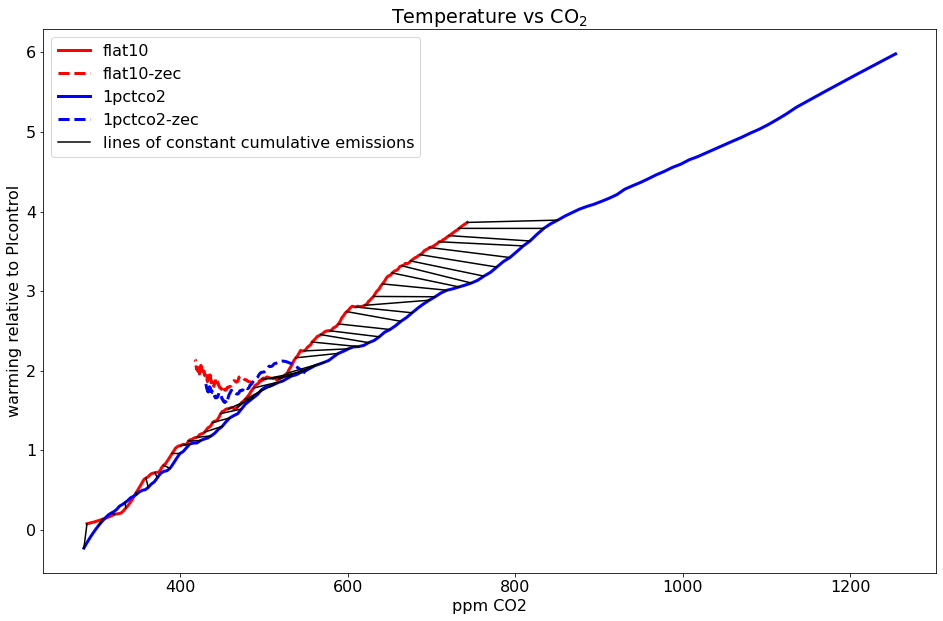

In [27]:
smoothing_window = 21

plt.plot(tmco2_annual_flat10, savgol_filter(warming_flat10,smoothing_window), color='red', linewidth=3)
plt.plot(tmco2_annual_zec, savgol_filter(warming_zec,smoothing_window), color='red', linestyle='dashed', linewidth=3)

plt.plot(co2_1pctco2, savgol_filter(warming_1pctco2,smoothing_window), color='blue', linewidth=3)
plt.plot(zec_co2, savgol_filter(zec_tas,smoothing_window), color='blue', linestyle='dashed', linewidth=3)

for i in range(len(ladder_times)):
    ind_flat10 = int(ladder_times[i])
    emiss = ind_flat10 * 10.
    ind_1pctco2 = np.argmin(abs(emissions_1pctco2 - emiss))
    plt.plot([co2_1pctco2[ind_1pctco2], tmco2_annual_flat10[ind_flat10] ], [savgol_filter(warming_1pctco2,smoothing_window)[ind_1pctco2], savgol_filter(warming_flat10,smoothing_window)[ind_flat10]], color='black')
   

plt.title('Temperature vs CO$_2$')
plt.xlabel('ppm CO2')
plt.ylabel('warming relative to PIcontrol')
plt.legend(['flat10','flat10-zec','1pctco2','1pctco2-zec', 'lines of constant cumulative emissions'])